In [13]:
""" gp.py

https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py

Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement

    Expected improvement acquisition function.

    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    if greater_is_better:
        scaling_factor = (1)
    else:
        scaling_factor = -1

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter

    Proposes the next hyperparameter to sample the loss function for.

    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.

    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation

    Uses Gaussian Processes to optimise the loss function `sample_loss`.

    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [3]:
# set up grid

lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

array([ 0.375     , -2.15789474])

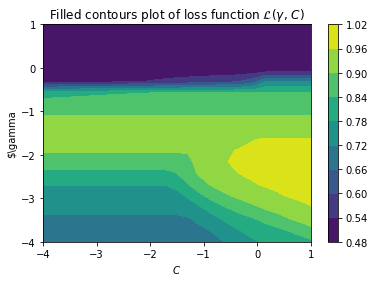

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc

rc('text', usetex=False)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma')
#plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.show()

In [21]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=100, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=True)

c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer 

c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer 

c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
c:\users\chapm\anaconda3\lib\site-packages\ipykernel\__main__.py:163: VisibleDeprecationWarning: using a boolean instead of an integer 

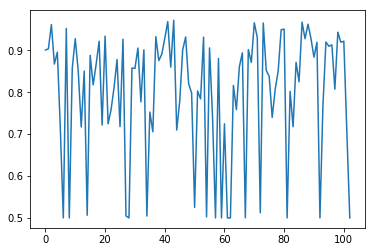

In [22]:
plt.plot(yp)

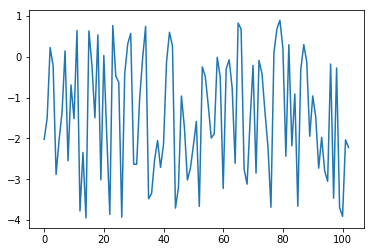

In [23]:
plt.plot(xp[:, 0])

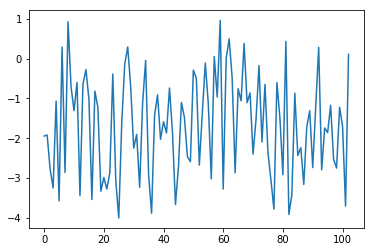

In [24]:
plt.plot(xp[:, 1])